# Sentiment Analysis - Comparing a Rule-Based vs. Two ML-based Models

Purpose: Sentiment Analysis is a Natural Language Processing (NLP) technique used to determine whether a piece of text is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

For this notebook, I am analyzing the sentiments of ~500 survey questions from surveys that measure masculinity. In effect, I am looking to see whether the beliefs and behaviors that are being measured contain positive/neutral/negative sentiments.

I am comparing a rule-based (lexicon-based) method (VADER) against a machine-learning based model (RoBERTa).

Inspiration: 
- https://www.youtube.com/watch?v=QpzMWQvxXWk&t=201s
- https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

## Imports and Setup

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [303]:
df = pd.read_csv('./Data/Questions_Final.csv')
print(df.shape)
df.head()

(458, 7)


,ID,Scale,Year of Publication,Nickname,Factor,Reverse Coded,Question Text
0,1,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,NaN,It is best to keep your emotions hidden
1,2,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,In general‚ I will do anything to win
2,3,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,If I could‚ I would frequently change sexual p...
3,4,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,If there is going to be violence‚ I find a way...
4,5,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,It is important to me that people think I am h...


# VADER 

In [304]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [305]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Question Text']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/458 [00:00<?, ?it/s]

In [306]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders = vaders.merge(df, how='left')

In [307]:
# Now we have sentiment score and metadata
vaders.head()

,ID,neg,neu,pos,compound,Scale,Year of Publication,Nickname,Factor,Reverse Coded,Question Text
0,1,0.000,0.625,0.375,0.6369,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,NaN,It is best to keep your emotions hidden
1,2,0.000,0.612,0.388,0.5859,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,In general‚ I will do anything to win
2,3,0.000,1.000,0.000,0.0000,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,If I could‚ I would frequently change sexual p...
3,4,0.167,0.833,0.000,-0.2960,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,If there is going to be violence‚ I find a way...
4,5,0.000,0.833,0.167,0.2023,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,It is important to me that people think I am h...


### Plot VADER Results

In [308]:
# ax = sns.barplot(data=vaders, x='Nickname', y='compound')
# ax.set_title('Compund Score by Measure Name')
# plt.xticks(rotation=65)
# plt.show()

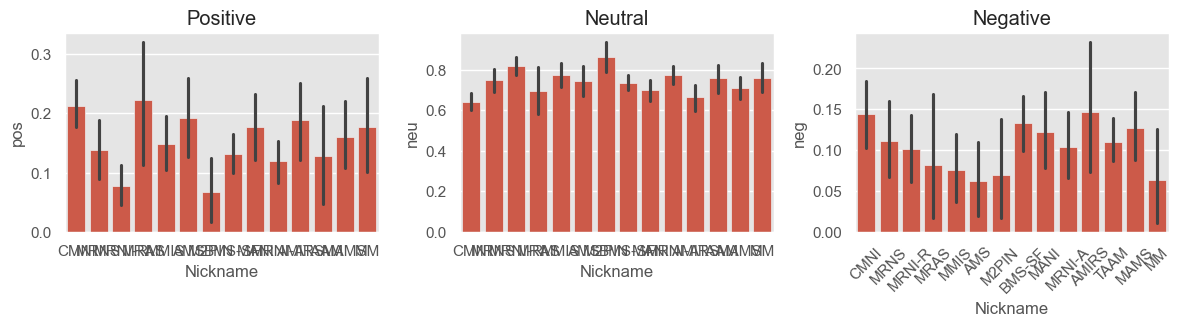

In [309]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Nickname', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Nickname', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Nickname', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# RoBERTa

In [310]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [311]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [312]:
def polarity_scores_roberta(phrase):
    encoded_text = tokenizer(phrase, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [313]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Question Text']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/458 [00:00<?, ?it/s]

In [314]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
results_df = results_df.merge(df, how='left')

results_df.head()

,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Scale,Year of Publication,Nickname,Factor,Reverse Coded,Question Text
0,1,0.000,0.625,0.375,0.6369,0.159830,0.732099,0.108071,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,NaN,It is best to keep your emotions hidden
1,2,0.000,0.612,0.388,0.5859,0.011003,0.215077,0.773920,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,In general‚ I will do anything to win
2,3,0.000,1.000,0.000,0.0000,0.128896,0.749415,0.121689,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,If I could‚ I would frequently change sexual p...
3,4,0.167,0.833,0.000,-0.2960,0.341258,0.616999,0.041743,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,If there is going to be violence‚ I find a way...
4,5,0.000,0.833,0.167,0.2023,0.059397,0.664210,0.276393,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,It is important to me that people think I am h...


### Plot RoBERTa Results

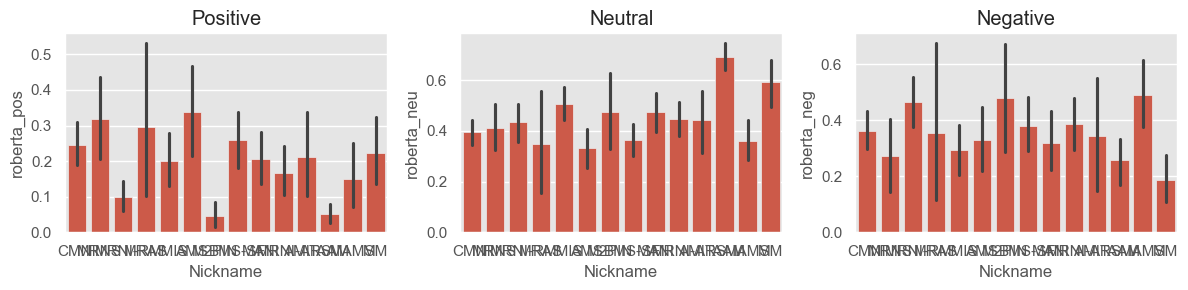

In [315]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='Nickname', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Nickname', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Nickname', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Hugging Face

In [319]:
# Import PyTorch
import torch

# Hugging Face model
from transformers import pipeline

In [344]:
# Define pipeline

# Other Example Models: https://huggingface.co/models?pipeline_tag=text-classification
# model = "distilbert-base-uncased-finetuned-sst-2-english"
# model = "ProsusAI/finbert"
model = "SamLowe/roberta-base-go_emotions"
# model= "facebook/bart-large-mnli"

classifier = pipeline(task="zero-shot-classification", 
                      model=model) 

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [345]:
# Put reviews in a list
sequences = df['Question Text'].to_list()

# Define the candidate labels 
candidate_labels = ["positive", "neutral", "negative"]

# Set the hyppothesis template
hypothesis_template = "The sentiment of this review is {}."

# Prediction results
hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

# Save the output as a dataframe
hf_prediction = pd.DataFrame(hf_prediction)

# Take a look at the data
hf_prediction.head()

,sequence,labels,scores
0,It is best to keep your emotions hidden,"[neutral, negative, positive]","[0.6482795476913452, 0.24048110842704773, 0.11..."
1,In general‚ I will do anything to win,"[neutral, negative, positive]","[0.5012969374656677, 0.3639771044254303, 0.134..."
2,If I could‚ I would frequently change sexual p...,"[neutral, negative, positive]","[0.837143063545227, 0.11154185235500336, 0.051..."
3,If there is going to be violence‚ I find a way...,"[neutral, negative, positive]","[0.6879739761352539, 0.22147619724273682, 0.09..."
4,It is important to me that people think I am h...,"[neutral, negative, positive]","[0.7518817782402039, 0.18879619240760803, 0.05..."


In [346]:
scored_df = hf_prediction

scored_df['hf_neg'] = [x[scored_df['labels'].values[ind].index('negative')] for ind, x in enumerate(scored_df['scores'].values)]
scored_df['hf_neu'] = [x[scored_df['labels'].values[ind].index('neutral')] for ind, x in enumerate(scored_df['scores'].values)]
scored_df['hf_pos'] = [x[scored_df['labels'].values[ind].index('positive')] for ind, x in enumerate(scored_df['scores'].values)]

scored_df.head()

,sequence,labels,scores,hf_neg,hf_neu,hf_pos
0,It is best to keep your emotions hidden,"[neutral, negative, positive]","[0.6482795476913452, 0.24048110842704773, 0.11...",0.240481,0.648280,0.111239
1,In general‚ I will do anything to win,"[neutral, negative, positive]","[0.5012969374656677, 0.3639771044254303, 0.134...",0.363977,0.501297,0.134726
2,If I could‚ I would frequently change sexual p...,"[neutral, negative, positive]","[0.837143063545227, 0.11154185235500336, 0.051...",0.111542,0.837143,0.051315
3,If there is going to be violence‚ I find a way...,"[neutral, negative, positive]","[0.6879739761352539, 0.22147619724273682, 0.09...",0.221476,0.687974,0.090550
4,It is important to me that people think I am h...,"[neutral, negative, positive]","[0.7518817782402039, 0.18879619240760803, 0.05...",0.188796,0.751882,0.059322


In [347]:
# The question's measure names
hf_prediction['Nickname'] = df['Nickname']

# Drop the columns that we do not need
#hf_prediction = hf_prediction.drop(['labels', 'scores'], axis=1)

# Take a look at the data
hf_prediction.head()

,sequence,labels,scores,hf_neg,hf_neu,hf_pos,Nickname
0,It is best to keep your emotions hidden,"[neutral, negative, positive]","[0.6482795476913452, 0.24048110842704773, 0.11...",0.240481,0.648280,0.111239,CMNI
1,In general‚ I will do anything to win,"[neutral, negative, positive]","[0.5012969374656677, 0.3639771044254303, 0.134...",0.363977,0.501297,0.134726,CMNI
2,If I could‚ I would frequently change sexual p...,"[neutral, negative, positive]","[0.837143063545227, 0.11154185235500336, 0.051...",0.111542,0.837143,0.051315,CMNI
3,If there is going to be violence‚ I find a way...,"[neutral, negative, positive]","[0.6879739761352539, 0.22147619724273682, 0.09...",0.221476,0.687974,0.090550,CMNI
4,It is important to me that people think I am h...,"[neutral, negative, positive]","[0.7518817782402039, 0.18879619240760803, 0.05...",0.188796,0.751882,0.059322,CMNI


### Plot Hugging Face Results

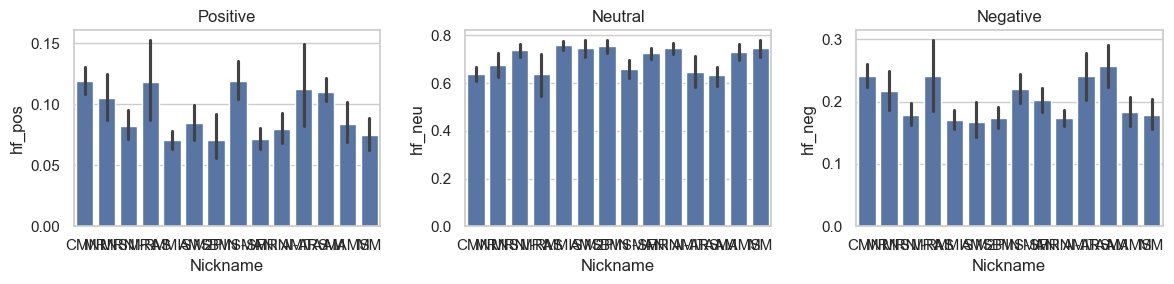

In [348]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=hf_prediction, x='Nickname', y='hf_pos', ax=axs[0])
sns.barplot(data=hf_prediction, x='Nickname', y='hf_neu', ax=axs[1])
sns.barplot(data=hf_prediction, x='Nickname', y='hf_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Compare Results

In [349]:
# hf_prediction = hf_prediction.drop(['Nickname'], axis=1)

hf_prediction['ID'] = range(1, len(hf_prediction)+1)

# Strip any spaces that might affect the merging process
results_df['Question Text'] = results_df['Question Text'].str.strip()
hf_prediction['sequence'] = hf_prediction['sequence'].str.strip()

# Perform the merge
compare_df = pd.merge(results_df, hf_prediction, on='ID', how='inner')

compare_df = compare_df.drop(['sequence'], axis=1)


In [350]:
# Comparison of Overall Scores

dict_results = { "Hugging Face Pos: ": compare_df.loc[:, 'hf_pos'].mean(),
                "Roberta Pos: ": compare_df.loc[:, 'roberta_pos'].mean(),
                "Vader Pos: ": compare_df.loc[:, 'vader_pos'].mean(),
                "Hugging Face Neu: ": compare_df.loc[:, 'hf_neu'].mean(),
                "Roberta Neu: ": compare_df.loc[:, 'roberta_neu'].mean(),
                "Vader Neu: ": compare_df.loc[:, 'vader_neu'].mean(),
                "Hugging Face Neg: ": compare_df.loc[:, 'hf_neg'].mean(),
                "Roberta Neg: ": compare_df.loc[:, 'roberta_neg'].mean(),
                "Vader Neg: ": compare_df.loc[:, 'vader_neg'].mean(),
               }
dict_results

{'Hugging Face Pos: ': 0.09518639664836716,
 'Roberta Pos: ': 0.21479871720924576,
 'Vader Pos: ': 0.15635589519650653,
 'Hugging Face Neu: ': 0.7019172368091267,
 'Roberta Neu: ': 0.4236767043697131,
 'Vader Neu: ': 0.7314279475982534,
 'Hugging Face Neg: ': 0.20289636780731543,
 'Roberta Neg: ': 0.36152457692594303,
 'Vader Neg: ': 0.11221834061135372}

In [351]:
from tabulate import tabulate

# Function to calculate the number of rows where each sentiment is the greatest
def count_max_rows(df, cols):
    return (df[cols].idxmax(axis=1).value_counts()).reindex(cols, fill_value=0)

# Columns for each sentiment model
vader_cols = ['vader_neg', 'vader_neu', 'vader_pos']
hf_cols = ['hf_neg', 'hf_neu', 'hf_pos']
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']

# Calculate counts for each model
vader_counts = count_max_rows(compare_df, vader_cols)
hf_counts = count_max_rows(compare_df, hf_cols)
roberta_counts = count_max_rows(compare_df, roberta_cols)

# Create a new DataFrame from the counts
summary_df = pd.DataFrame({
    'VADER': vader_counts,
    'Hugging Face': hf_counts,
    'RoBERTa': roberta_counts
}).transpose()

reshaped_df = summary_df.stack().reset_index()
reshaped_df.columns = ['Model', 'Score_Type', 'Count']
reshaped_df['Sentiment'] = reshaped_df['Score_Type'].str.split('_').str[1]

# Pivot to get the desired 3x3 table
pivot_table = reshaped_df.pivot(index='Model', columns='Sentiment', values='Count')


title = "# of Predictions by Model (n=458)"
print(title.center(40))  # Adjust the number of spaces depending on the width of your table

# Print the pivot table using tabulate for pretty formatting
print(tabulate(pivot_table, headers='keys', tablefmt='fancy_grid'))

   # of Predictions by Model (n=458)    
╒══════════════╤═══════╤═══════╤═══════╕
│ Model        │   neg │   neu │   pos │
╞══════════════╪═══════╪═══════╪═══════╡
│ Hugging Face │     8 │   450 │     0 │
├──────────────┼───────┼───────┼───────┤
│ RoBERTa      │   156 │   219 │    83 │
├──────────────┼───────┼───────┼───────┤
│ VADER        │    15 │   428 │    15 │
╘══════════════╧═══════╧═══════╧═══════╛


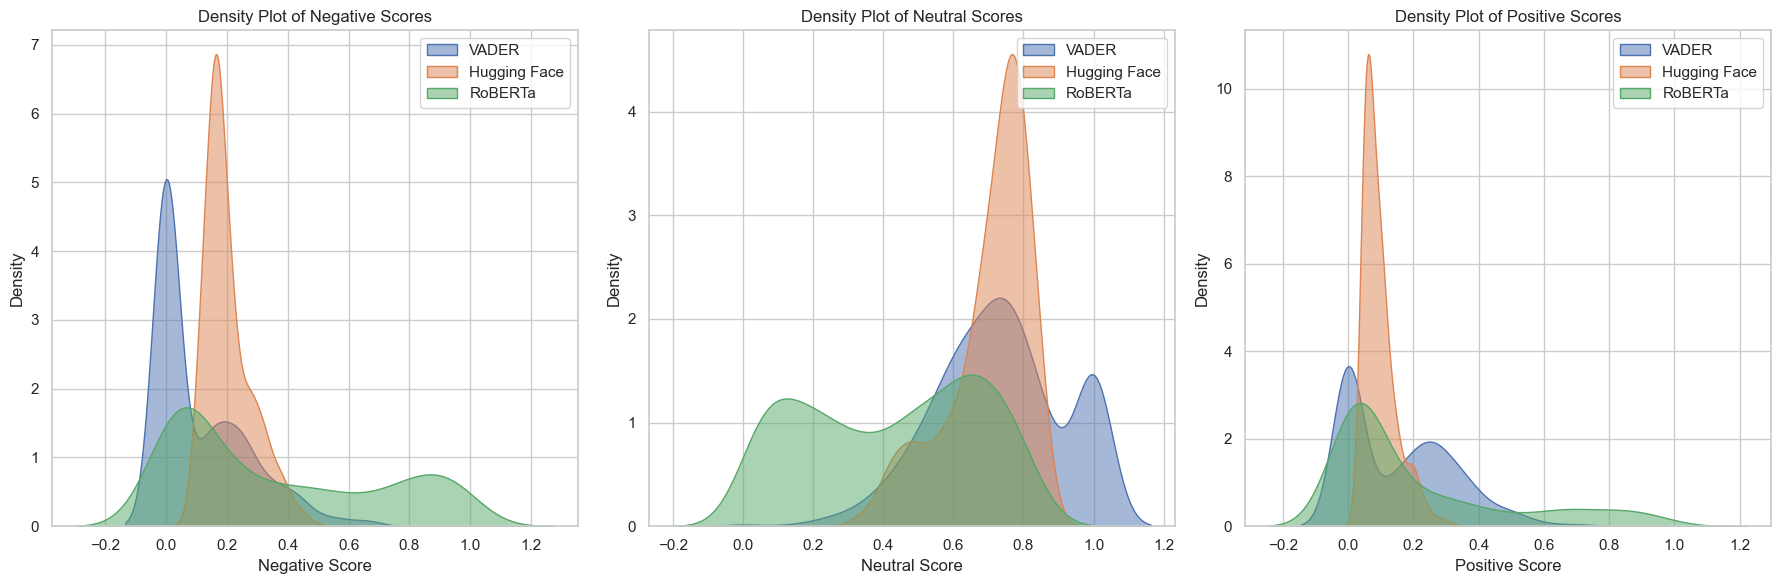

In [352]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure with a size and set up three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot density for Negative Scores
sns.kdeplot(data=compare_df, x="vader_neg", label="VADER", fill=True, common_norm=False, alpha=0.5, ax=axes[0])
sns.kdeplot(data=compare_df, x="hf_neg", label="Hugging Face", fill=True, common_norm=False, alpha=0.5, ax=axes[0])
sns.kdeplot(data=compare_df, x="roberta_neg", label="RoBERTa", fill=True, common_norm=False, alpha=0.5, ax=axes[0])
axes[0].set_title('Density Plot of Negative Scores')
axes[0].set_xlabel('Negative Score')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot density for Neutral Scores
sns.kdeplot(data=compare_df, x="vader_neu", label="VADER", fill=True, common_norm=False, alpha=0.5, ax=axes[1])
sns.kdeplot(data=compare_df, x="hf_neu", label="Hugging Face", fill=True, common_norm=False, alpha=0.5, ax=axes[1])
sns.kdeplot(data=compare_df, x="roberta_neu", label="RoBERTa", fill=True, common_norm=False, alpha=0.5, ax=axes[1])
axes[1].set_title('Density Plot of Neutral Scores')
axes[1].set_xlabel('Neutral Score')
axes[1].set_ylabel('Density')
axes[1].legend()

# Plot density for Positive Scores
sns.kdeplot(data=compare_df, x="vader_pos", label="VADER", fill=True, common_norm=False, alpha=0.5, ax=axes[2])
sns.kdeplot(data=compare_df, x="hf_pos", label="Hugging Face", fill=True, common_norm=False, alpha=0.5, ax=axes[2])
sns.kdeplot(data=compare_df, x="roberta_pos", label="RoBERTa", fill=True, common_norm=False, alpha=0.5, ax=axes[2])
axes[2].set_title('Density Plot of Positive Scores')
axes[2].set_xlabel('Positive Score')
axes[2].set_ylabel('Density')
axes[2].legend()

# Adjust layout
plt.tight_layout()

plt.savefig('./Visualizations/sentiment_score_density_plots.png', dpi=300)
# Display the plot
plt.show()

In [353]:
compare_df['vader_pos'].describe()

count    458.000000
mean       0.156356
std        0.163515
min        0.000000
25%        0.000000
50%        0.139500
75%        0.275750
max        0.737000
Name: vader_pos, dtype: float64

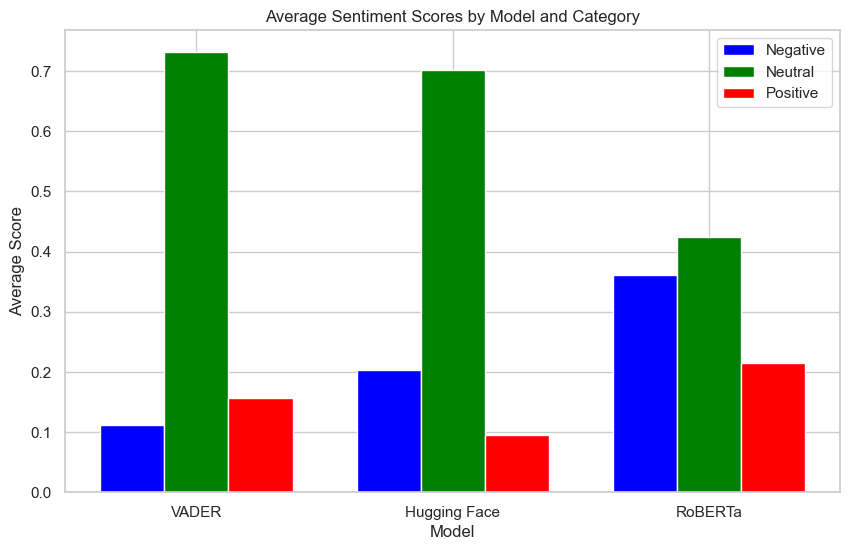

In [354]:
# Assuming 'compare_df' is your DataFrame with the specified structure
# Calculate the mean scores for each sentiment category
mean_scores = {
    'Negative': compare_df[['vader_neg', 'hf_neg', 'roberta_neg']].mean(),
    'Neutral': compare_df[['vader_neu', 'hf_neu', 'roberta_neu']].mean(),
    'Positive': compare_df[['vader_pos', 'hf_pos', 'roberta_pos']].mean()
}

# Create a DataFrame from the mean scores dictionary
mean_df = pd.DataFrame(mean_scores)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(mean_scores))  # the label locations
width = 0.25  # the width of the bars

# Plotting each sentiment score group by algorithm
ax.bar(x - width, mean_scores['Negative'], width, label='Negative', color='blue')
ax.bar(x, mean_scores['Neutral'], width, label='Neutral', color='green')
ax.bar(x + width, mean_scores['Positive'], width, label='Positive', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Average Score')
ax.set_title('Average Sentiment Scores by Model and Category')
ax.set_xticks(x)
ax.set_xticklabels(['VADER', 'Hugging Face', 'RoBERTa'])
ax.legend()


plt.savefig('./Visualizations/average_sentiment_score_bar_plots.png', dpi=300)
plt.show()

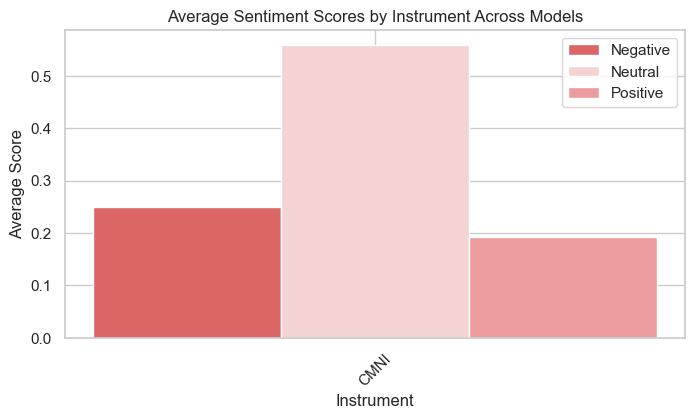

In [374]:
# Calculate the mean across the models for each sentiment
compare_df['mean_neg'] = compare_df[['vader_neg', 'hf_neg', 'roberta_neg']].mean(axis=1)
compare_df['mean_neu'] = compare_df[['vader_neu', 'hf_neu', 'roberta_neu']].mean(axis=1)
compare_df['mean_pos'] = compare_df[['vader_pos', 'hf_pos', 'roberta_pos']].mean(axis=1)

# UNCOMMENT DEPENDING ON WHICH SURVEYS TO MEASURE
# compare_df = compare_df[compare_df["Scale"] == "Conformity to Masculine Norms Inventory"]


# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 4))
nicknames = compare_df['Nickname_x'].unique()

# Position of bars on x-axis
ind = range(len(nicknames))

# Bar width
width = 0.25

# Plotting
neg_bars = ax.bar(ind, compare_df.groupby('Nickname_x')['mean_neg'].mean(), width, label='Negative',  color='#dc6666')
neu_bars = ax.bar([p + width for p in ind], compare_df.groupby('Nickname_x')['mean_neu'].mean(), width, label='Neutral',  color='#f4d3d3')
pos_bars = ax.bar([p + width*2 for p in ind], compare_df.groupby('Nickname_x')['mean_pos'].mean(), width, label='Positive',  color='#ec9c9c')

# Insert x-axis labels
ax.set_xlabel('Instrument')
ax.set_ylabel('Average Score')
ax.set_title('Average Sentiment Scores by Instrument Across Models')
ax.set_xticks([p + width for p in ind])
ax.set_xticklabels(nicknames)

# Adding legend
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.savefig('./Visualizations/average_sentiment_score_by_instrument_bar_plots.png', dpi=300)
plt.show()

In [396]:
# Assuming 'compare_df' is your DataFrame with the specified structure
# Calculate the mean scores for each sentiment category
mean_scores = {
    'Negative': compare_df[['vader_neg', 'hf_neg', 'roberta_neg', 'mean_neg']].mean(),
    'Neutral': compare_df[['vader_neu', 'hf_neu', 'roberta_neu', 'mean_neu']].mean(),
    'Positive': compare_df[['vader_pos', 'hf_pos', 'roberta_pos', 'mean_pos']].mean()
}

# Create a DataFrame from the mean scores dictionary
mean_df = pd.DataFrame(mean_scores)

mean_df
# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))
# x = np.arange(len(mean_scores))  # the label locations
# width = 0.25  # the width of the bars

# # Plotting each sentiment score group by algorithm
# ax.bar(x - width, mean_scores['Negative'], width, label='Negative', color='#dc6666')
# ax.bar(x, mean_scores['Neutral'], width, label='Neutral', color='#f4d3d3')
# ax.bar(x + width, mean_scores['Positive'], width, label='Positive', color='#ec9c9c')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel('Model')
# ax.set_ylabel('Average Score')
# ax.set_title('Average Sentiment Scores by Model')
# ax.set_xticks(x)
# ax.set_xticklabels(['VADER', 'Hugging Face', 'RoBERTa'])
# ax.legend()


# plt.savefig('./Visualizations/CMNI_average_sentiment_score_bar_plots.png', dpi=300)
# plt.show()

,Negative,Neutral,Positive
hf_neg,0.241808,NaN,NaN
hf_neu,NaN,0.638898,NaN
hf_pos,NaN,NaN,0.119295
mean_neg,0.249008,NaN,NaN
mean_neu,NaN,0.558954,NaN
mean_pos,NaN,NaN,0.192042
roberta_neg,0.361024,NaN,NaN
roberta_neu,NaN,0.394378,NaN
roberta_pos,NaN,NaN,0.244598
vader_neg,0.144191,NaN,NaN
